In [13]:
import numpy as np
import keras
import warnings
from matplotlib import pyplot as plt
import cv2
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import preprocess_input

In [2]:
def image_process(img,r_size,c_size):
    scaled_image = cv2.resize(img, (r_size, c_size))
    rot_image = np.rot90(scaled_image,-1)
    return rot_image

In [3]:
dire = './finger/'
filename = 'FiveOpen.MOV'

In [4]:
def extract_image_data(dire = dire, filename = filename,r_size=224,c_size=224):
    file = dire+ filename
    vidcap = cv2.VideoCapture(file)
    success,image = vidcap.read()
    flag = True
    image_list = []
    cnt = 0
    while flag:
        flag,img = vidcap.read()
        if flag:
            image_list += [image_process(img,r_size,c_size)]
            cnt += 1
    return image_list

In [5]:
image_list = extract_image_data(dire,filename)
print(image_list[0].shape)
print(len(image_list))

(224, 224, 3)
294


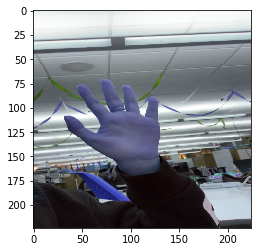

In [6]:
imgplot = plt.imshow(image_list[0])

In [7]:
image_dataset = []
category_dataset = []
cat = 0
proj = {}
for filename in ['FiveOpen.MOV','ok.MOV','fistback.MOV','fistfront.MOV','thumbup.MOV','twofingers.MOV','yeah.MOV']:
    image_list = extract_image_data(dire,filename)
    image_dataset += image_list
    category_dataset += [cat for _ in image_list]
    proj[cat] = filename.split('.')[0]
    cat += 1
image_dataset = np.asarray(image_dataset)
category_dataset = np.asarray(category_dataset)
category_dataset = keras.utils.to_categorical(category_dataset)

In [8]:
print(image_dataset.shape)

(2329, 224, 224, 3)


In [9]:
print(category_dataset.shape)

(2329, 7)


In [14]:
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras import models

In [11]:
r_size=224
c_size=224
model = keras.applications.MobileNet(include_top=False, 
                                                  weights='imagenet', 
                                                  input_shape=(r_size, c_size, 3), 
                                                  pooling=None)

In [59]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [100]:
%%time
processed_input = model.predict(image_dataset)

Wall time: 27min 8s


In [101]:
from sklearn.model_selection import train_test_split

dat_train, dat_test, y_train, y_test = train_test_split(processed_input, category_dataset, test_size=0.2, random_state=42, stratify=category_dataset)

In [102]:
print(image_dataset[0].shape)
print(processed_input.shape)

(224, 224, 3)
(2329, 7, 7, 1024)


In [104]:
top_model = models.Sequential()
top_model.add(layers.Flatten(input_shape=(7, 7, 1024)))
top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(64, activation='relu'))
top_model.add(layers.Dense(7, activation='softmax'))

top_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
top_model.fit(dat_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(dat_test, y_test))

Train on 1863 samples, validate on 466 samples
Epoch 1/10
1863/1863 [==============================] - 11s 6ms/step - loss: 3.7140 - acc: 0.6420 - val_loss: 0.0240 - val_acc: 0.9936
Epoch 2/10
1863/1863 [==============================] - 4s 2ms/step - loss: 0.3451 - acc: 0.9351 - val_loss: 0.6336 - val_acc: 0.9421
Epoch 3/10
1863/1863 [==============================] - 4s 2ms/step - loss: 0.1745 - acc: 0.9758 - val_loss: 0.0094 - val_acc: 0.9979
Epoch 4/10
1863/1863 [==============================] - 4s 2ms/step - loss: 0.0581 - acc: 0.9871 - val_loss: 0.3984 - val_acc: 0.9700
Epoch 5/10
1863/1863 [==============================] - 4s 2ms/step - loss: 0.0552 - acc: 0.9903 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/10
1863/1863 [==============================] - 4s 2ms/step - loss: 0.0588 - acc: 0.9893 - val_loss: 2.4792e-06 - val_acc: 1.0000
Epoch 7/10
1863/1863 [==============================] - 4s 2ms/step - loss: 0.0905 - acc: 0.9882 - val_loss: 1.1921e-07 - val_acc: 1.0000
Ep

In [105]:
# save trained model
model.save('model/MobileNet.h5')

In [107]:
def get_classification_metrics(X_test, y_test):
    pred = top_model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))
    
get_classification_metrics(dat_test, y_test)

[[59  0  0  0  0  0  0]
 [ 0 90  0  0  0  0  0]
 [ 0  0 28  0  0  0  0]
 [ 0  0  0 73  0  0  0]
 [ 0  0  0  0 61  0  0]
 [ 0  0  0  0  0 62  0]
 [ 0  0  0  0  0  0 93]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        73
           4       1.00      1.00      1.00        61
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        93

   micro avg       1.00      1.00      1.00       466
   macro avg       1.00      1.00      1.00       466
weighted avg       1.00      1.00      1.00       466



In [15]:
from keras.models import load_model
# load model
model = load_model('model/MobileNet.h5')
top_model = load_model('model/top_model.h5')

In [4]:
import json

with open('proj.json', 'r') as fp:
    proj = json.load(fp)

In [16]:
def get_command(img,r_size=224,c_size=224):
    scaled_image = cv2.resize(img, (r_size, c_size))
    cmd_id = top_model.predict_classes(model.predict(np.asarray([scaled_image])))[0]
    return cmd_id

In [17]:
proj = {"0": "fist", "1": "five", "2": "thumb", "3": "yeah"}

In [7]:
%%time
proj[str(get_command(image_dataset[2000]))]

NameError: name 'image_dataset' is not defined

In [2]:
import copy
import cv2
import numpy as np
from keras.models import load_model
import time
import collections
# General Settings
prediction = ''
action = ''
score = 0
img_counter = 500


# Turn on/off the ability to save images, or control Philips Hue/Sonos
save_images, selected_gesture = False, 'peace'
smart_home = True

gesture_names = {0: 'Fist',
                 1: 'L',
                 2: 'Okay',
                 3: 'Palm',
                 4: 'Peace'}

model = load_model('model/VGG_cross_validated.h5')

cmd_chain = collections.deque()

def predict_rgb_image(img):
    result = gesture_names[model.predict_classes(img)[0]]
    print(result)
    return (result)


def predict_rgb_image_vgg(image):
    image = np.array(image, dtype='float32')
    image /= 255
    pred_array = model.predict(image)
    #print(f'pred_array: {pred_array}')
    result = gesture_names[np.argmax(pred_array)]
    #print(f'Result: {result}')
    #print(max(pred_array[0]))
    score = float("%0.2f" % (max(pred_array[0]) * 100))
    #print(result)
    return result, score


# parameters
cap_region_x_begin = 0.5  # start point/total width
cap_region_y_end = 0.8  # start point/total width
threshold = 60  # binary threshold
blurValue = 41  # GaussianBlur parameter
bgSubThreshold = 100
learningRate = 0

# variableslt
isBgCaptured = 0  # bool, whether the background captured
triggerSwitch = False  # if true, keyboard simulator works


def remove_background(frame):
    fgmask = bgModel.apply(frame, learningRate=learningRate)
    kernel = np.ones((3, 3), np.uint8)
    fgmask = cv2.erode(fgmask, kernel, iterations=1)
    res = cv2.bitwise_and(frame, frame, mask=fgmask)
    return res


cap = cv2.VideoCapture(0)
if cap.isOpened():
    bgModel = cv2.createBackgroundSubtractorMOG2(0, bgSubThreshold)
    print('Camara Turned On')
else:
    print('Error')
    
count = 0
while(1):

    ret, frame = cap.read()
    frame=cv2.flip(frame,1)

    #frame = image_dataset[530]
    #cmd_id = get_command(frame)
    #cmd = proj[str(cmd_id)]
    #print(cmd)
    #cv2.putText(frame,cmd, (120,120), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

    frame = cv2.bilateralFilter(frame, 5, 50, 100)  # smoothing filter

    cv2.rectangle(frame, (int(cap_region_x_begin * frame.shape[1]), 0),(frame.shape[1], int(cap_region_y_end * frame.shape[0])), (255, 0, 0), 2)

    img = remove_background(frame)

    img = img[0:int(cap_region_y_end * frame.shape[0]),int(cap_region_x_begin * frame.shape[1]):frame.shape[1]]  # clip the ROI

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (blurValue, blurValue), 0)

    # cv2.imshow('blur', blur)

    ret, thresh = cv2.threshold(blur, threshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # copies 1 channel BW image to all 3 RGB channels
    target = np.stack((thresh,) * 3, axis=-1)
    target = cv2.resize(target, (224, 224))
    target = target.reshape(1, 224, 224, 3)
    if(count == 0):
        prediction, score = predict_rgb_image_vgg(target)

    thresh1 = copy.deepcopy(thresh)
    _, contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    length = len(contours)
    maxArea = -1
    if length > 0:
        for i in range(length):  # find the biggest contour (according to area)
            temp = contours[i]
            area = cv2.contourArea(temp)
            if area > maxArea:
                maxArea = area
                ci = i

        res = contours[ci]
        hull = cv2.convexHull(res)

        if(len(contours) > 1): 
            cnt = contours[1]
            area = cv2.contourArea(cnt)

            M = cv2.moments(cnt)
            if(M['m00'] > 0):
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])

            cmd_chain.append([prediction,area,(cx,cy)])
            
        drawing = np.zeros(img.shape, np.uint8)
        cv2.drawContours(drawing, [res], 0, (0, 255, 0), 2)
        cv2.drawContours(drawing, [hull], 0, (0, 0, 255), 3)

    cv2.imshow('output', drawing)
    while len(cmd_chain) > 10:
        cmd_chain.popleft()
    print(cmd_chain)

    cv2.putText(frame,prediction+str(score), (120,120), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

    #print(prediction,score)

    cv2.imshow('frame',frame)
    
    count += 1
    count = count % 5



    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
    elif k == ord('b'):  # press 'b' to capture the background
        bgModel = cv2.createBackgroundSubtractorMOG2(0, bgSubThreshold)
        time.sleep(2)
        isBgCaptured = 1
        #print('Background captured')
    
cv2.destroyAllWindows()
cap.release()

C:\Users\24156\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Camara Turned On
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)]])
deque([['L', 60249.0, (122, 121)], ['Fist', 383.5, (12, 247)]])
deque([['L', 60249.0, (122, 121)], ['Fist', 383.5, (12, 247)], ['Fist', 397.0, (12, 247)]])
deque([['L', 60249.0, (122, 121)], ['Fist', 383.5, (12, 247)], ['Fist', 397.0, (12, 247)], ['Fist', 258.0, (10, 244)]])
deque([['L', 60249.0, (122, 121)], ['Fist', 383.5, (12, 247)], ['Fist', 397.0, (12, 247)], ['Fist', 258.0, (10, 244)], ['L', 273.0, (10, 244)]])
deque([['L', 60249.0, (122, 121)], ['Fist', 383.5, (12, 247)], ['Fist', 397.0, (12, 247)], ['Fist', 258.0, (10, 244)], ['L', 273.0